# Simulations

In [5]:
import importlib
import color_maps as cm
import my_functions as mf
import filepaths as fp
import variables
import figure_label_names as fln
from matplotlib.ticker import ScalarFormatter, FuncFormatter

mf = importlib.reload(mf)
fp = importlib.reload(fp)
cm = importlib.reload(cm)

import pandas as pd
import numpy as np
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import matplotlib.animation as animation
from scipy import interpolate
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit



from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, check_X_y
import pickle
from sklearn.metrics import accuracy_score, f1_score
from sklearn.dummy import DummyClassifier



In [6]:
def reload_libraries(): 
    import importlib
    import my_functions as mf
    import filepaths as fp
    import color_maps as cm
    import variables
    import figure_label_names as fln
    mf = importlib.reload(mf)
    fp = importlib.reload(fp)
    cm = importlib.reload(cm)
    variables = importlib.reload(variables)
    fln = importlib.reload(fln)
    print('done')

def get_gaussian_noise_intensity(melt_df, mean, std_dev): 
    melt_df_copy = melt_df.copy()
    # Calculate the number of datapoints
    num_datapoints = melt_df_copy.shape[0]
    # Generate Gaussian noise
    noise = np.random.normal(mean, std_dev, num_datapoints)
    melt_df_copy.loc[:, 'intensity_noise'] = melt_df_copy.loc[:, 'intensity'] + noise
    return melt_df_copy


def get_accuracy_from_model(noise_vector_df): 
    #get the new data from the vector df
    X, y = mf.get_X_y_from_vector_df(noise_vector_df)
    # Perform LDA transformation
    lda_transformed_data = lda_pipeline.transform(X.values)
    # Perform GMM prediction on the transformed data
    gmm_predictions = gmm_pipeline.predict(pd.DataFrame(lda_transformed_data))
    # Create a DataFrame to associate original labels with cluster assignments
    results_df = pd.DataFrame({'true_class': y, 'gmm_predicted_class': gmm_predictions})
    #get the map
    map = pd.read_csv(fp.intermediate_data_filepath + '/' + 'gmm_map.csv')
    #now apply this majority map
    class_results_df = mf.convert_GMM_to_class_labels(results_df, map)
    #calculate the accuracy and f1
    accuracy, f1 = mf.get_accuracy_and_f1(class_results_df.loc[:, 'true_gmm_class'], class_results_df.loc[:, 'gmm_predicted_class'])
    return accuracy, f1

def train_model_and_get_results(vector_df):
    X, y = mf.get_X_y_from_vector_df(vector_df)
    # Splitting the data into training and testing sets with a 70-30 split ratio
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    
    
    #make the pipeline
    lda_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('lda', LinearDiscriminantAnalysis())
    ])
    
    #GMM pipeline
    gmm_pipeline = Pipeline([
        ('gmm', GaussianMixture(n_components=4))  # Adjust n_components for GMM
    ])
    
    #fit_transform the lda_df
    train_lda = pd.DataFrame(lda_pipeline.fit_transform(X_train, y_train))
    #fit_transform the lda_df
    test_lda = pd.DataFrame(lda_pipeline.transform(X_test))
    
    #make the train_lda_df
    train_lda_df = pd.DataFrame(lda_pipeline.fit_transform(X_train, y_train))
    #predict the train labels
    train_predictions = gmm_pipeline.fit_predict(train_lda_df)
    #make the test_lda_df
    test_lda_df = pd.DataFrame(lda_pipeline.transform(X_test))
    #make the test predictions
    test_predictions = gmm_pipeline.predict(test_lda_df)
    # Create a DataFrame to associate original labels with cluster assignments
    train_df = pd.DataFrame({'true_class': y_train, 'gmm_predicted_class': train_predictions})
    #create the test df
    test_df = pd.DataFrame({'true_class': y_test, 'gmm_predicted_class': test_predictions})

    #get the map based on majority voting
    map = train_df.groupby('true_class').apply(mf.majority_vote).reset_index().rename({
        'true_class': 'gmm_class',
        0: 'gmm_class_numerical'}, axis = 1)
    
    #now apply this majority map
    class_train_df = mf.convert_GMM_to_class_labels(train_df, map)
    class_test_df = mf.convert_GMM_to_class_labels(test_df, map)

    return class_train_df, class_test_df


def get_interpolated_df(results_df, window_length): 
    # Filter the DataFrame based on the specified window_length
    df = results_df[results_df.loc[:, 'window_length'] == window_length]
    # Extract center wavelengths and corresponding accuracies
    wavelengths = df.loc[:, 'center_wavelength']
    accuracies = df.loc[:, 'test_accuracy']
    # Determine the minimum and maximum wavelengths from the filtered data
    min_wavelength = wavelengths.min()
    max_wavelength = wavelengths.max()
    
    # Generate uniformly spaced wavelengths within the range
    interpolated_wavelengths = np.arange(min_wavelength, max_wavelength + 1, 1)
    # Create a linear interpolation function using scipy.interpolate.interp1d
    interp_func = interpolate.interp1d(wavelengths, accuracies, kind='linear')
    # Perform interpolation to calculate accuracies at each original wavelength
    interpolated_accuracies = interp_func(interpolated_wavelengths)
    
    # Create a new DataFrame to store interpolated data
    interpolated_df = pd.DataFrame({
        'window_length': [window_length]*len(interpolated_wavelengths),  # Original window lengths
        'center_wavelength': interpolated_wavelengths,             # Original wavelengths
        'test_accuracy': interpolated_accuracies      # Interpolated accuracies
    })
    return interpolated_df


def get_equidistant_undersampling(melt_df, desired_num_points):
    min_wavelength = melt_df.loc[:, 'wavelength'].min()
    max_wavelength = melt_df.loc[:, 'wavelength'].max()
    new_wavelengths = np.linspace(min_wavelength, max_wavelength, desired_num_points)
    equidistand_undersampling_df = melt_df.sort_values('wavelength').groupby('measurement_index').apply(resample_and_interpolate, desired_num_points = desired_num_points, new_wavelengths = new_wavelengths).reset_index().drop('level_1', axis = 1)
    return equidistand_undersampling_df


def resample_and_interpolate(group, desired_num_points, new_wavelengths):
    class_array = [list(group['Class'])[0]]*desired_num_points
    # Interpolate intensity values for the new wavelengths
    new_intensity_values = np.interp(new_wavelengths, group['wavelength'], group['intensity'])
    # Create a new DataFrame with interpolated values for the group
    new_group_df = pd.DataFrame({'Class': class_array,
                                'wavelength': new_wavelengths,
                                 'intensity': new_intensity_values})
    return new_group_df

def get_accuracy_of_equidistant_undersampled_model(melt_df, desired_num_points): 
    #get the undersampled dataframe
    undersampled_melt_df = get_equidistant_undersampling(melt_df, desired_num_points)
    #get the vecvector_df
    vector_df = mf.get_vector_df(undersampled_melt_df, 'intensity')
    #train the model and get the result
    class_train_df, class_test_df = train_model_and_get_results(vector_df)
    #calculate accuracy and f1 score
    test_accuracy, f1 = get_accuracy_and_f1(class_test_df.loc[:, 'true_gmm_class'], class_test_df.loc[:, 'gmm_predicted_class'])
    train_accuracy, f1 = get_accuracy_and_f1(class_train_df.loc[:, 'true_gmm_class'], class_train_df.loc[:, 'gmm_predicted_class'])
    return train_accuracy, test_accuracy

## Import data

In [7]:
data_filepath = fp.data_filepath
image_filepath = fp.figure_filepath
filename = os.listdir(data_filepath)[0]
#read in the data
vector_df = pd.read_feather(data_filepath + '/' + filename).reset_index().rename({'index': 'measurement_index'}, axis = 1)
vector_df.iloc[:, 2:] = vector_df.iloc[:, 2:].astype('float64')
#get the melted df
melt_df = mf.get_melt_df(vector_df)

In [8]:
vector_df.to_csv(fp.data_filepath + '/' + 'original_data.csv', index = False)

## Noise simulations

### Gaussian noise

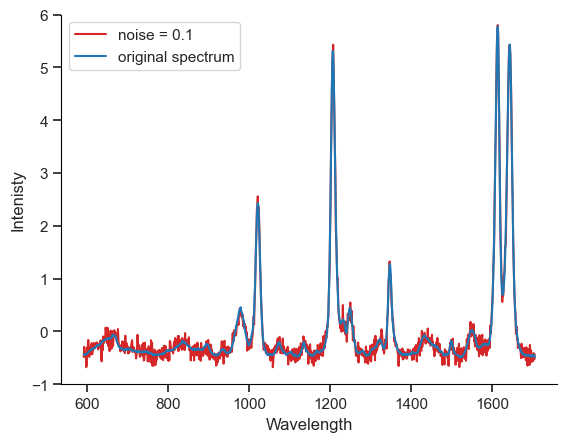

In [5]:
#this is the original spectrum 
original_spectrum_df = mf.get_measurement_spectrum(0,melt_df)

frames = 50


# Create a figure and axis
fig, ax = plt.subplots()
sns.set(style="white")
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Initialize scatter plot with an empty plot
scatter = sns.scatterplot(ax=ax)

def update_noise(frame): 
    # Clear previous plot
    ax.clear()
    # Update data for the plot (example: sinusoidal wave animation)
    std_dev_array = np.linspace(0.1, 1, frames)
    #get the standard deviation for this frame
    std_dev = std_dev_array[frame]
    #now generate the noise for the gaussian data
    noisy_data = get_gaussian_noise_intensity(mf.get_measurement_spectrum(0, melt_df), 0, std_dev)
    #now plot the scatterplot
    sns.lineplot(data =noisy_data, x ='wavelength', y = 'intensity_noise', color = 'tab:red',  label = 'noise = ' + str(std_dev))
    #plot the original spectrum first
    sns.lineplot(data = original_spectrum_df, x ='wavelength', y = 'intensity', label = 'original spectrum', alpha = 1, color = 'tab:blue')
    plt.ylim(-1,6)
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Intenisty')

# Create the animation
ani = animation.FuncAnimation(fig, update_noise, frames=frames, interval=100)
ani.save(fp.video_filepath + '/' + 'noise_animation.mp4', writer='ffmpeg', fps=10)

#### Original model on the noise

In [537]:
answer = input('Do you want to run this? This might take a while')
    
if answer == 'y': 
    filename = input('wwat is the filenmae')
    num_observations = 5
    #import the model
    # Load the LDA model
    with open(fp.model_filepath + '/' + 'lda_pipeline.pkl', 'rb') as lda_file:
        lda_pipeline = pickle.load(lda_file)
    
    # Load the GMM model
    with open(fp.model_filepath + '/' + 'gmm_pipeline.pkl', 'rb') as gmm_file:
        gmm_pipeline = pickle.load(gmm_file)

    std_dev_array = np.arange(0, 1, 0.01)
    accuracy_array = []
    current_observation_array = []
    current_std_array = []
    
    for std_dev in std_dev_array:
        for num_observation in range(num_observations):
            #the dataframe with the added noise
            noise_melt_df = get_gaussian_noise_intensity(melt_df,mean, std_dev)
            #convert the melt df to a dataframe
            noise_vector_df = get_vector_df(melt_df, 'intensity_noise')
            accuracy, f1 = get_accuracy_from_model(noise_vector_df)
            accuracy_array += [accuracy]
            current_std_array += [std_dev]
            current_observation_array += [num_observation]
    
    noise_performance_results = pd.DataFrame({'standard_deviation': current_std_array,
                                          'accuracy': accuracy_array, 
                                         'current_observation': current_observation_array})
    noise_performance_results.to_csv(fp.simulation_data_filepath + '/' + + filename + '.csv', index = False)


Do you want to run this? This might take a while n


In [ ]:
noise_performance_results = pd.read_csv()

In [9]:

sns.lineplot(noise_performance_results, x = 'standard_deviation', y = 'accuracy')
sns.scatterplot(noise_performance_results, x = 'standard_deviation', y = 'accuracy', s = variables.scatterplot_size)
plt.xlabel('Standard deviation', fontsize = variables.fontsize)
plt.ylabel('Accuracy',fontsize = variables.fontsize)
# plt.legend(fontsize = variables.fontsize)
plt.savefig(fp.figure_filepath + '/' + 'Accuracy_vs_std_original_model.png', bbox_inches = 'tight')
plt.show()

NameError: name 'noise_performance_results' is not defined

#### train model on the higher noise

In [586]:
answer = input('Do you want to run this? This might take a while')
if answer == 'y': 
    filename = input('what is the filename')
    std_dev_array = np.arange(0, 1, 0.02)
    train_accuracy_array = []
    test_accuracy_array = []
    dummy_accuracy_array = []
    current_observation_array = []
    current_std_array = []
    
    num_observations = 5
    
    for std_dev in std_dev_array:
        print(std_dev)
        for observation_num in range(num_observations):
            #get the noise onto the data
            noise_melt_df = get_gaussian_noise_intensity(melt_df,mean, std_dev)
            #make it into a vector
            noise_vector_df = get_vector_df(melt_df, 'intensity_noise')
            #get the results
            class_train_df, class_test_df = train_model_and_get_results(noise_vector_df)
            #get the train and test accuracy
            train_accuracy, f1 = get_accuracy_and_f1(class_train_df.loc[:, 'true_gmm_class'], class_train_df.loc[:, 'gmm_predicted_class'])
            test_accuracy, f1 = get_accuracy_and_f1(class_test_df.loc[:, 'true_gmm_class'], class_test_df.loc[:, 'gmm_predicted_class'])
            train_accuracy_array += [train_accuracy]
            test_accuracy_array += [test_accuracy]
            dummy_accuracy_array += [mf.get_dummy_accuracy(noise_vector_df)]
            current_std_array += [std_dev]
            current_observation_array += [observation_num]

    #save the results
    noise_performance_adjusted_model_results_df = pd.DataFrame({'standard_deviation': current_std_array,
                                             'observation_num': current_observation_array,
                                            'train_accuracy': train_accuracy_array,
                                             'test_accuracy': test_accuracy_array})
    
    noise_performance_adjusted_model_results_df = pd.melt(noise_performance_adjusted_model_results_df, id_vars=['standard_deviation', 'observation_num'], var_name='train_or_test', value_name='score')
    #save the file
    mf.save_dataframe_without_overwrite(noise_performance_adjusted_model_results_df, fp.simulation_data_filepath, filename, False)
    print(done)

Do you want to run this? This might take a while n


In [104]:
reload_libraries()
answer = input('Do you want to run this? This might take a while')
if answer == 'y': 
    filename = input('what is the filename')
    std_dev_array = np.arange(0, 1, 0.02)
    train_accuracy_array = []
    test_accuracy_array = []
    dummy_accuracy_array = []
    current_observation_array = []
    current_std_array = []
    mean = 0
    num_observations = 5
    
    for std_dev in std_dev_array:
        print(std_dev)
        for observation_num in range(num_observations):
            #get the noise onto the data
            noise_melt_df = get_gaussian_noise_intensity(melt_df,mean, std_dev)
            #make it into a vector
            noise_vector_df = mf.get_vector_df(noise_melt_df, 'intensity_noise')
            #get the results
            class_train_df, class_test_df = train_model_and_get_results(noise_vector_df)
            #get the train and test accuracy
            train_accuracy, f1 = get_accuracy_and_f1(class_train_df.loc[:, 'true_gmm_class'], class_train_df.loc[:, 'gmm_predicted_class'])
            test_accuracy, f1 = get_accuracy_and_f1(class_test_df.loc[:, 'true_gmm_class'], class_test_df.loc[:, 'gmm_predicted_class'])
            train_accuracy_array += [train_accuracy]
            test_accuracy_array += [test_accuracy]
            dummy_accuracy_array += [mf.get_dummy_accuracy(noise_vector_df)]
            current_std_array += [std_dev]
            current_observation_array += [observation_num]

    #save the results
    noise_performance_adjusted_model_results_df = pd.DataFrame({'standard_deviation': current_std_array,
                                             'observation_num': current_observation_array,
                                            'train_accuracy': train_accuracy_array,
                                             'test_accuracy': test_accuracy_array,
                                            'dummy_accuracy': dummy_accuracy_array})
    
    noise_performance_adjusted_model_results_df = pd.melt(noise_performance_adjusted_model_results_df, id_vars=['standard_deviation', 'observation_num'], var_name='train_or_test', value_name='score')
    #save the file
    # noise_performance_adjusted_model_results_df.to_csv(fp.simulation_data_filepath + '/' + filename + '.csv', index = False)
    mf.save_dataframe_without_overwrite(noise_performance_adjusted_model_results_df, fp.simulation_data_filepath, filename, False)
    print('done')

done


Do you want to run this? This might take a while y
what is the filename noise_performance


0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7000000000000001
0.72
0.74
0.76
0.78
0.8
0.8200000000000001
0.84
0.86
0.88
0.9
0.92
0.9400000000000001
0.96
0.98
done


#### calculate SNR

In [11]:
reload_libraries()
mean = 0
std = 2
def get_SNR(melt_df, std): 
    """
    Calculate the Signal-to-Noise Ratio (SNR) for a given melted DataFrame.

    Parameters:
    - melt_df (pd.DataFrame): Melted DataFrame containing columns 'wavelength' and 'intensity'.
    - std (float): Standard deviation parameter for generating Gaussian noise.
    """
    min_intensity = melt_df.loc[:, 'intensity'].min()
    baseline_corrected_melt_df = melt_df.copy()
    baseline_corrected_melt_df.loc[:, 'intensity'] = melt_df.loc[:, 'intensity'] - min_intensity
    
    noise_melt_df = mf.get_gaussian_noise_intensity(baseline_corrected_melt_df, mean, std)
    std = noise_melt_df.groupby(['wavelength'], as_index = False)['intensity_noise'].std()
    signal = mf.get_mean_spectrum(baseline_corrected_melt_df)
    SNR = signal.loc[:, 'intensity']/std.loc[:, 'intensity_noise']
    
    return SNR.mean()

# Extract unique standard deviations from a DataFrame
std_array = noise_performance_adjusted_model_results_df.loc[:, 'standard_deviation'].unique()

# Calculate SNR for each unique standard deviation
SNR_array = []
for std in std_array:
    SNR_array += [get_SNR(melt_df, std)]

# Create a DataFrame mapping standard deviations to SNR values
std_snr_map = pd.DataFrame({'standard_deviation': std_array,
                             'Signal-to-Noise Ratio': SNR_array})

done


#### display the results

In [12]:
#read the dataframe for the noise adjusted model
noise_performance_adjusted_model_results_df = pd.read_csv(fp.simulation_data_filepath + '/' + 'noise_performance.csv')
noise_performance_adjusted_model_results_df =  noise_performance_adjusted_model_results_df.replace({'train_accuracy': 'noise-trained model: train accuracy',
                                                                                                    'test_accuracy': 'noise-trained model: test accuracy',
                                                                                                    'dummy_accuracy': 'dummy accuracy'
                                                                                                   })
#read the dataframe for model trained without noise                                                    
noise_performance_results_df = pd.read_csv(fp.simulation_data_filepath + '/' + 'score_vs_std_original_model.csv')
noise_performance_results_df.loc[:, 'train_or_test'] = ['noise-free model']*noise_performance_results_df.shape[0]
noise_performance_results_df = noise_performance_results_df.rename(columns={'accuracy': 'score'})
noise_performance_results_df = noise_performance_results_df.rename({'current_observation': 'observation_num'}, axis =1)

#concatenate the two dataframes
noise_performance_results_df_reordered = noise_performance_results_df[noise_performance_adjusted_model_results_df.columns]
#concatenate them
concat_df = pd.concat([noise_performance_results_df_reordered, noise_performance_adjusted_model_results_df])
#convert to snr
# Extract unique standard deviations from a DataFrame
std_array = concat_df.loc[:, 'standard_deviation'].unique()
# Calculate SNR for each unique standard deviation
SNR_array = []
for std in std_array:
    SNR_array += [get_SNR(melt_df, std)]
# Create a DataFrame mapping standard deviations to SNR values
std_snr_map = pd.DataFrame({'standard_deviation': std_array,
                             'Signal-to-Noise Ratio': SNR_array})
#convert to snr
concat_df = pd.merge(concat_df, std_snr_map,how = 'left')
#do the snr in the logscale
concat_df.loc[:, 'log Signal-to-Noise Ratio'] = np.log10(concat_df.loc[:, 'Signal-to-Noise Ratio'] )

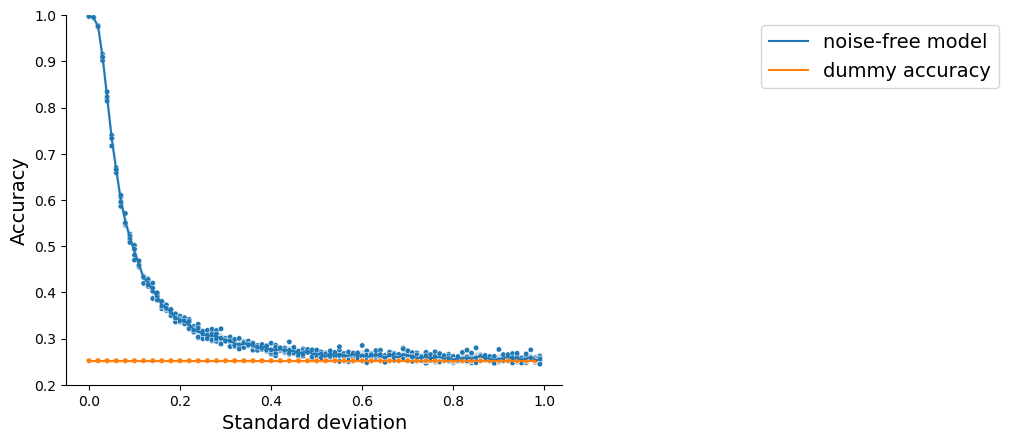

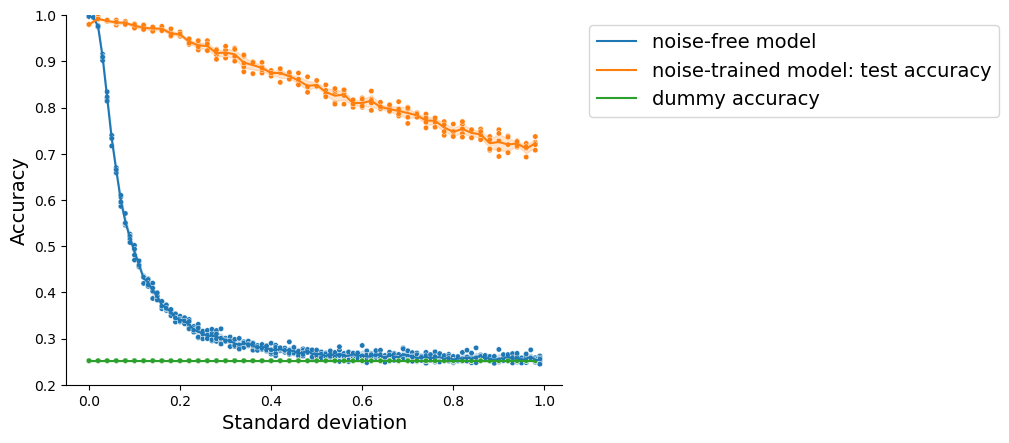

In [23]:
#filter for the first figure
concat_df.loc[:, 'train_or_test'].unique()
filt_fig1 = (concat_df.loc[:, 'train_or_test'] == 'dummy accuracy') | (concat_df.loc[:, 'train_or_test'] == 'noise-free model')

#filter for the second figure
concat_df.loc[:, 'train_or_test'].unique()
filt_fig2 = (concat_df.loc[:, 'train_or_test'] == 'dummy accuracy') | (concat_df.loc[:, 'train_or_test'] == 'noise-free model') | (concat_df.loc[:, 'train_or_test'] == 'noise-trained model: test accuracy')

#first plot the first figure
#start the plotting
lineplot = sns.lineplot(concat_df[filt_fig1], x= 'standard_deviation', y = 'score', hue= 'train_or_test')
lineplot.legend_.set_title('')
plt.legend(loc='upper right', bbox_to_anchor=(1.9, 1), fontsize = variables.fontsize)

sns.scatterplot(concat_df[filt_fig1], x= 'standard_deviation', y = 'score', hue= 'train_or_test', legend = False,s = variables.scatterplot_size)
# Hide the right and upper spines (axes)
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.ylim(0.2, 1)
plt.xlabel('Standard deviation', fontsize = variables.fontsize)
plt.ylabel('Accuracy', fontsize = variables.fontsize)
plt.savefig(fp.figure_filepath + '/' + 'Standar_deviation_vs_accuracy_for_noise.png', bbox_inches = 'tight')
plt.show()

#plot the second figure
lineplot = sns.lineplot(concat_df[filt_fig2], x= 'standard_deviation', y = 'score', hue= 'train_or_test')
lineplot.legend_.set_title('')
plt.legend(loc='upper right', bbox_to_anchor=(1.9, 1), fontsize = variables.fontsize)

sns.scatterplot(concat_df[filt_fig2], x= 'standard_deviation', y = 'score', hue= 'train_or_test', legend = False,s = variables.scatterplot_size)
# Hide the right and upper spines (axes)
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.ylim(0.2, 1)
plt.xlabel('Standard deviation', fontsize = variables.fontsize)
plt.ylabel('Accuracy', fontsize = variables.fontsize)
plt.savefig(fp.figure_filepath + '/' + 'Standar_deviation_vs_accuracy_for_noise.png', bbox_inches = 'tight')
plt.show()

In [39]:
filt = (concat_df.loc[:, 'score'] > 0.9) & (concat_df.loc[:, 'score']<0.92) & (concat_df.loc[:, 'train_or_test'] == 'noise-trained model: test accuracy')
concat_df[filt]

,standard_deviation,observation_num,train_or_test,score,Signal-to-Noise Ratio,log Signal-to-Noise Ratio
820,0.28,0,noise-trained model: test accuracy,0.913747,3.191050,0.503934
822,0.28,2,noise-trained model: test accuracy,0.919137,3.191050,0.503934
823,0.28,3,noise-trained model: test accuracy,0.904313,3.191050,0.503934
826,0.30,1,noise-trained model: test accuracy,0.907008,3.032743,0.481836
827,0.30,2,noise-trained model: test accuracy,0.915094,3.032743,0.481836
828,0.30,3,noise-trained model: test accuracy,0.916442,3.032743,0.481836
830,0.32,0,noise-trained model: test accuracy,0.909704,2.890760,0.461012
831,0.32,1,noise-trained model: test accuracy,0.900270,2.890760,0.461012
832,0.32,2,noise-trained model: test accuracy,0.911051,2.890760,0.461012
835,0.34,0,noise-trained model: test accuracy,0.911051,2.764004,0.441539


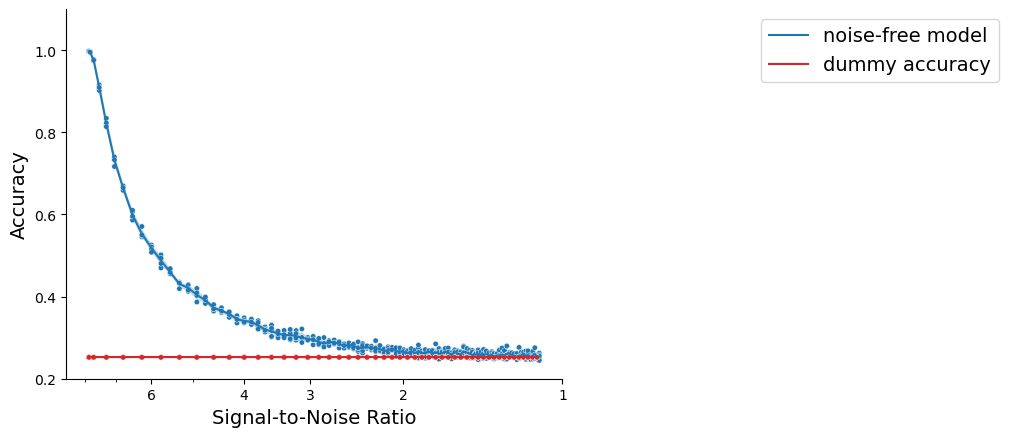

In [33]:
concat_df_fig_1 = concat_df[filt_fig1]

hue_colors = {'dummy accuracy': 'tab:red', 'noise-free model': 'tab:blue'}

lineplot = sns.lineplot(concat_df_fig_1, x= 'Signal-to-Noise Ratio', y = 'score', hue= 'train_or_test', palette=hue_colors)
lineplot.legend_.set_title('')
plt.legend(loc='upper right', bbox_to_anchor=(1.9, 1), fontsize = variables.fontsize)
#convert to snr
concat_df_fig_1 = pd.merge(concat_df_fig_1, std_snr_map,how = 'left')


scatterplot = sns.scatterplot(concat_df_fig_1, x= 'Signal-to-Noise Ratio', y = 'score', hue= 'train_or_test',palette=hue_colors, legend = False,s = variables.scatterplot_size)
scatterplot.set(xscale = 'log')
#Hide the right and upper spines (axes)
ax = plt.gca()
ax.invert_xaxis()
# Choose specific values for tick marks on the x-axis
custom_ticks = [6, 4, 3, 2 ,1]
scatterplot.set(xticks=custom_ticks)

# Use FuncFormatter to format x-axis tick labels
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# Choose specific values for tick marks on the x-axis
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.ylim(0.2, 1.1)
plt.xlabel('Signal-to-Noise Ratio', fontsize = variables.fontsize)
plt.ylabel('Accuracy', fontsize = variables.fontsize)
plt.savefig(fp.figure_filepath + '/' + 'accuracy_vs_std_noise_free.png', bbox_inches = 'tight')
plt.show()

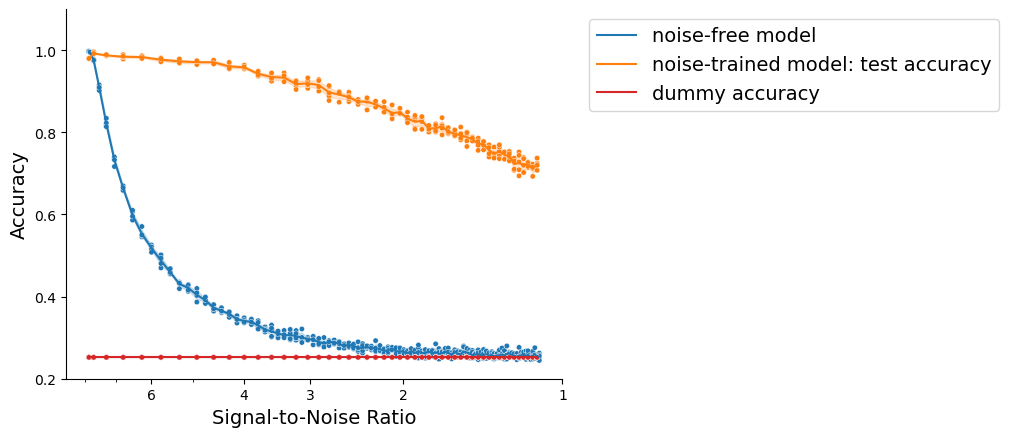

In [32]:
concat_df_fig_2 = concat_df[filt_fig2]

hue_colors = {'dummy accuracy': 'tab:red', 'noise-free model': 'tab:blue', 'noise-trained model: test accuracy': 'tab:orange'}

lineplot = sns.lineplot(concat_df_fig_2, x= 'Signal-to-Noise Ratio', y = 'score', hue= 'train_or_test', palette=hue_colors)
lineplot.legend_.set_title('')
plt.legend(loc='upper right', bbox_to_anchor=(1.9, 1), fontsize = variables.fontsize)
#convert to snr
concat_df_fig_2 = pd.merge(concat_df_fig_2, std_snr_map,how = 'left')


scatterplot = sns.scatterplot(concat_df_fig_2, x= 'Signal-to-Noise Ratio', y = 'score', hue= 'train_or_test',palette=hue_colors, legend = False,s = variables.scatterplot_size)
scatterplot.set(xscale = 'log')
#Hide the right and upper spines (axes)
ax = plt.gca()
ax.invert_xaxis()
# Choose specific values for tick marks on the x-axis
custom_ticks = [6, 4, 3, 2 ,1]
scatterplot.set(xticks=custom_ticks)

# Use FuncFormatter to format x-axis tick labels
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# Choose specific values for tick marks on the x-axis
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.ylim(0.2, 1.1)
plt.xlabel('Signal-to-Noise Ratio', fontsize = variables.fontsize)
plt.ylabel('Accuracy', fontsize = variables.fontsize)
plt.savefig(fp.figure_filepath + '/' + 'accuracy_vs_std_noise_trained.png', bbox_inches = 'tight')
plt.show()

#### Fit the data

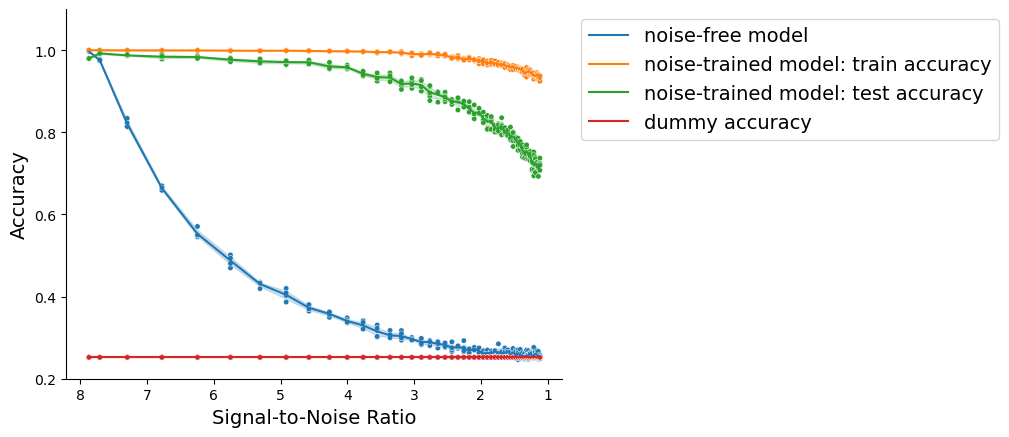

In [176]:
lineplot = sns.lineplot(concat_df, x= 'Signal-to-Noise Ratio', y = 'score', hue= 'train_or_test')
lineplot.legend_.set_title('')
plt.legend(loc='upper right', bbox_to_anchor=(1.9, 1), fontsize = variables.fontsize)
#convert to snr
concat_df = pd.merge(concat_df, std_snr_map,how = 'left')


scatterplot = sns.scatterplot(concat_df, x= 'Signal-to-Noise Ratio', y = 'score', hue= 'train_or_test', legend = False,s = variables.scatterplot_size)
#Hide the right and upper spines (axes)
ax = plt.gca()
ax.invert_xaxis()
# Choose specific values for tick marks on the x-axis
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.ylim(0.2, 1.1)
plt.xlabel('Signal-to-Noise Ratio', fontsize = variables.fontsize)
plt.ylabel('Accuracy', fontsize = variables.fontsize)
plt.savefig(fp.figure_filepath + '/' + 'Standar_deviation_vs_accuracy_for_noise.png', bbox_inches = 'tight')
plt.show()

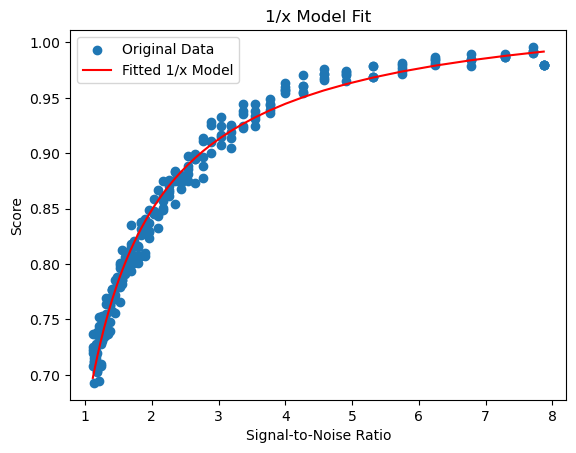

Fitted parameters: a = -0.3833804875782734, b = 1.0404665216510112
Uncertainties: a = 0.00321128607653541, b = 0.001742602235871816


In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the 1/x model function
def inverse_model(x, a, b):
    return a / x + b

# Your original code
curve_name = 'noise-trained model: test accuracy'
filt = (concat_df.loc[:, 'train_or_test'] == curve_name)
filt_concat_df = concat_df[filt]
data = filt_concat_df[['Signal-to-Noise Ratio', 'score']]

# Use curve_fit to fit the 1/x model to the data
x_data = filt_concat_df['Signal-to-Noise Ratio']
y_data = filt_concat_df['score']
params, covariance = curve_fit(inverse_model, x_data, y_data)

# Extract fitted parameters and uncertainties
a_fit, b_fit = params
a_uncertainty, b_uncertainty = np.sqrt(np.diag(covariance))

# Plot the original data and the fitted 1/x model
plt.scatter(x_data, y_data, label='Original Data')
plt.plot(x_data, inverse_model(x_data, a_fit, b_fit), label='Fitted 1/x Model', color='red')
plt.legend()
plt.xlabel('Signal-to-Noise Ratio')
plt.ylabel('Score')
plt.title('1/x Model Fit')
plt.show()

# Print fitted parameters and uncertainties
print(f"Fitted parameters: a = {a_fit}, b = {b_fit}")
print(f"Uncertainties: a = {a_uncertainty}, b = {b_uncertainty}")


In [226]:
import numpy as np
from scipy.optimize import curve_fit

# Define the inverse model function
def inverse_model(x, a, b):
    return a / x + b

# Assuming you have the fitted parameters
params, _ = curve_fit(inverse_model, x_data, y_data)

# Extract fitted parameters
a_fit, b_fit = params

# Calculate the predicted (fitted) values
y_predicted = inverse_model(x_data, a_fit, b_fit)

# Calculate the total sum of squares (TSS)
tss = np.sum((y_data - np.mean(y_data))**2)

# Calculate the residual sum of squares (RSS)
rss = np.sum((y_data - y_predicted)**2)

# Calculate R-squared
r_squared = 1 - (rss / tss)

print(f"R-squared: {r_squared}")ac

R-squared: 0.982897565761529


In [269]:
concat_df.isnull().sum()

standard_deviation           0
observation_num              0
train_or_test                0
score                        0
Signal-to-Noise Ratio        0
log Signal-to-Noise Ratio    0
dtype: int64

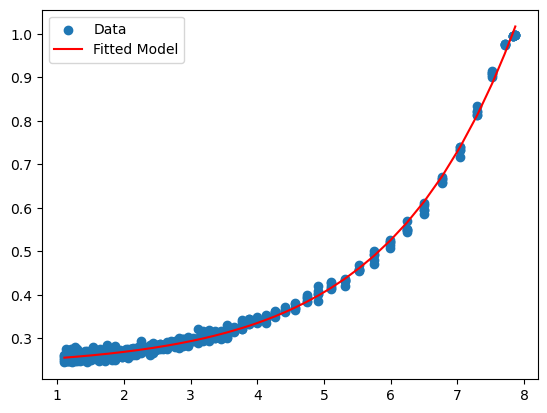

In [277]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def exponential_model(x, a, b, c, d):
    return a * np.exp(b * (x - c)) + d

curve_name = 'noise-free model'
filt = (concat_df.loc[:, 'train_or_test'] == curve_name)
filt_concat_df = concat_df[filt]
data = filt_concat_df[['Signal-to-Noise Ratio', 'score']]

# Provide initial guesses for parameters a, b, c, and d
initial_guesses = [1, 0.1, 1, -1]

# Use curve_fit to fit the model to the data
x_data = filt_concat_df['Signal-to-Noise Ratio']
y_data = filt_concat_df['score']
params, covariance = curve_fit(exponential_model, x_data, y_data, p0=initial_guesses, maxfev=10000)

# Extract fitted parameters and uncertainties
a_fit, b_fit, c_fit, d_fit = params
a_uncertainty, b_uncertainty, c_uncertainty, d_uncertainty = np.sqrt(np.diag(covariance))

# Plot the data and the fitted model
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, exponential_model(x_data, a_fit, b_fit, c_fit, d_fit), label='Fitted Model', color='red')
plt.legend()
plt.show()

In [278]:
from sklearn.metrics import r2_score

# Calculate the predicted values using the fitted model
y_pred = exponential_model(x_data, a_fit, b_fit, c_fit, d_fit)

# Calculate R-squared value
r_squared = r2_score(y_data, y_pred)

print(f'R-squared value: {r_squared}')

R-squared value: 0.9972780080035155


In [246]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

curve_name = 'noise-free model'
filt = (concat_df.loc[:, 'train_or_test'] == curve_name)
filt_concat_df = concat_df[filt]
data = filt_concat_df[['Signal-to-Noise Ratio', 'score']]

# Provide initial guesses for parameters a, b, and c
initial_guesses = [1, -1, 1]

# Use curve_fit to fit the model to the data
x_data = filt_concat_df['Signal-to-Noise Ratio']
y_data = filt_concat_df['score']
params, covariance = curve_fit(quadratic_model, x_data, y_data, p0=initial_guesses, maxfev=1000)

# Extract fitted parameters and uncertainties
a_fit, b_fit, c_fit = params
a_uncertainty, b_uncertainty, c_uncertainty = np.sqrt(np.diag(covariance))

# Plot the data and the fitted model
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, quadratic_model(x_data, a_fit, b_fit, c_fit), label='Fitted Model', color='red')
plt.legend()
plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

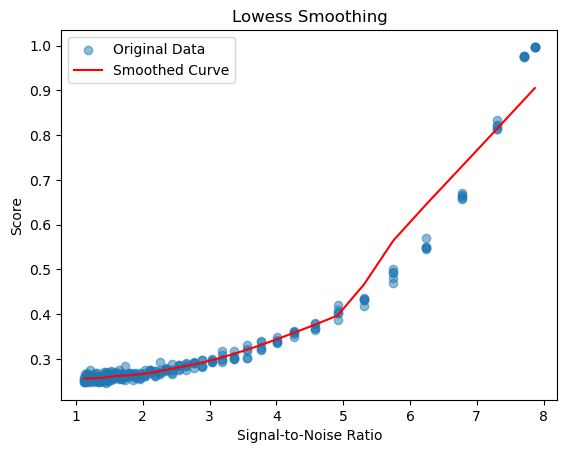

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Your original code
curve_name = 'noise-free model'
filt = (concat_df.loc[:, 'train_or_test'] == curve_name)
filt_concat_df = concat_df[filt]
data = filt_concat_df[['Signal-to-Noise Ratio', 'score']]

# Apply Lowess smoothing
smoothed = lowess(data['score'], data['Signal-to-Noise Ratio'], frac=0.3)

# Plot the original data and the smoothed curve
plt.scatter(data['Signal-to-Noise Ratio'], data['score'], label='Original Data', alpha=0.5)
plt.plot(smoothed[:, 0], smoothed[:, 1], label='Smoothed Curve', color='red')
plt.legend()
plt.xlabel('Signal-to-Noise Ratio')
plt.ylabel('Score')
plt.title('Lowess Smoothing')
plt.show()

In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Your original code
curve_name = 'noise-free model'
filt = (concat_df.loc[:, 'train_or_test'] == curve_name)
filt_concat_df = concat_df[filt]
data = filt_concat_df[['Signal-to-Noise Ratio', 'score']]

# Fit a 2nd order polynomial to the data
coefficients = np.polyfit(data['Signal-to-Noise Ratio'], data['score'], 6)
polynomial_fit = np.poly1d(coefficients)

# Generate x values for the fitted curve
x_fit = np.linspace(data['Signal-to-Noise Ratio'].min(), data['Signal-to-Noise Ratio'].max(), 100)

# Calculate y values using the polynomial fit
y_fit = polynomial_fit(x_fit)

# Plot the original data and the fitted polynomial
plt.scatter(data['Signal-to-Noise Ratio'], data['score'], label='Original Data', alpha=0.5)
plt.plot(x_fit, y_fit, label='2nd Order Polynomial Fit', color='red')
plt.legend()
plt.xlabel('Signal-to-Noise Ratio')
plt.ylabel('Score')
plt.title('2nd Order Polynomial Fit')
plt.show()


LinAlgError: SVD did not converge in Linear Least Squares

### Resolution simulation

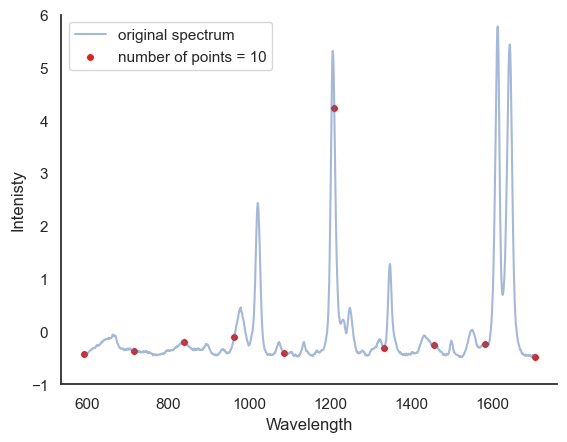

In [21]:
original_spectrum_df = mf.get_measurement_spectrum(0,melt_df)

# Create a figure and axis
fig, ax = plt.subplots()
sns.set(style="white")
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Initialize scatter plot with an empty plot
scatter = sns.scatterplot(ax=ax)

# Function to update the plot for each frame of the animation
def update(frame):
    # Clear previous plot
    ax.clear()
    # Update data for the plot (example: sinusoidal wave animation)
    num_datapoints_array = np.linspace(10, 300, frames)
    num_datapoints = int(num_datapoints_array[frame])
    sns.lineplot(data = original_spectrum_df, x ='wavelength', y = 'intensity', label = 'original spectrum', alpha = 0.5)
    sns.scatterplot(data =get_equidistant_undersampling(mf.get_measurement_spectrum(0, melt_df), num_datapoints), x ='wavelength', y = 'intensity', color = 'tab:red', s= 30,  label = 'number of points = ' + str(num_datapoints))
    plt.ylim(-1,6)
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Intenisty')
    return scatter

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=frames, interval=100)
ani.save('scatter_animation.mp4', writer='ffmpeg', fps=10)


In [473]:
answer = input('are you sure you want to run this code?')
if answer == 'y':
    num_observations = 5
    desired_num_datapoint_array = np.arange(20, 1000, 20)
    train_accuracy_array = []
    test_accuracy_array = []
    current_num_datapoints_array = []
    
    start_time = time.time()
    
    for desired_num_points in desired_num_datapoint_array: 
        print(desired_num_points)
        for ii in range(num_observations): 
            train_accuracy, test_accuracy = get_accuracy_of_equidistant_undersampled_model(melt_df, desired_num_points)
            train_accuracy_array += [train_accuracy]
            test_accuracy_array += [test_accuracy]
            observation_nr_array += [ii]
            current_num_datapoints_array += [desired_num_points]
        num_datapoints_array += [num_datapoints]
    
    end_time = time.time()
    seconds = end_time-start_time
    seconds_per_measurement = seconds/(len(desired_num_datapoint_array)*num_observations)
    
    sampling_step_results_df = pd.DataFrame({'num_datapoints': current_num_datapoints_array,
                                            'train_accuracy': train_accuracy_array,
                                             'test_accuracy': test_accuracy_array})
    sampling_step_results_df = pd.melt(sampling_step_results_df, id_vars='num_datapoints', var_name='train_or_test', value_name='score')
    sampling_step_results_df.to_csv(fp.simulation_data_filepath + '/' + 'score_vs_num_datapoints.csv', index = False)

are you sure you want to run this code? n


In [42]:
pd.read_csv(fp.simulation_data_filepath + '/' + 'score_vs_num_datapoints.csv').head(50)

,num_datapoints,train_or_test,score
0,20,train_accuracy,0.872568
1,20,train_accuracy,0.871795
2,20,train_accuracy,0.872805
3,40,train_accuracy,0.951080
4,40,train_accuracy,0.951080
5,40,train_accuracy,0.951080
6,60,train_accuracy,0.991228
7,60,train_accuracy,0.991228
8,60,train_accuracy,0.991228
9,80,train_accuracy,0.994265


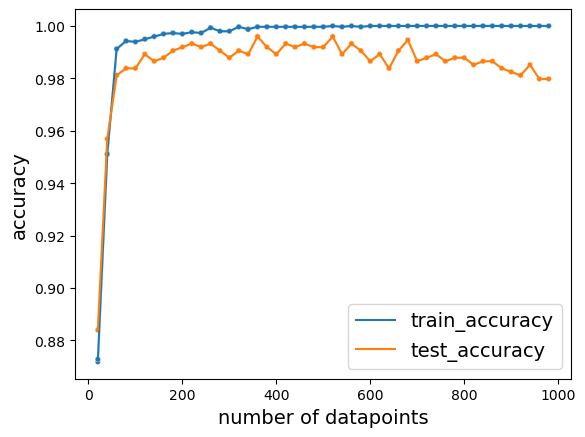

In [536]:
lineplot = sns.lineplot(data = sampling_step_results_df, x = 'num_datapoints', y = 'score', hue = 'train_or_test')
lineplot.legend_.set_title('')
sns.scatterplot(data = sampling_step_results_df, x = 'num_datapoints', y = 'score', hue = 'train_or_test', s= variables.scatterplot_size, legend=False)
plt.xlabel('number of datapoints', fontsize = variables.fontsize)
plt.ylabel('accuracy',fontsize = variables.fontsize)
plt.legend(fontsize = variables.fontsize)
plt.savefig(fp.figure_filepath + '/' + 'equidistant_undersampling_score.png', bbox_inches = 'tight')
plt.show()

### Spectrum importance

In [6]:
num_datapoints = mf.get_measurement_spectrum(0, melt_df).shape[0]

num_averaging_measurements = 2
stride = 100  # Stride
jump = 200

window_length_array = np.arange(20, 300, jump)

test_accuracy_array = []
center_wavelength_array = []
current_window_length_array = []
current_averaging_meas_array = []

answer = input('are you sure you want to run this code? This might take a while')
if answer == 'y': 
    filename = input('what is the filename?')
    filename = filename + '_stride_' + str(stride) + '_jump_' + str(jump)
    print(filename)
    #change the size of the window
    for window_length in window_length_array: 
        windows = [(i, i + window_length - 1) for i in range(0, num_datapoints - window_length + 2, stride)]
        print(window_length)
        #shift the windows over the spectrum
        for window_number in range(len(windows)):
            begin_index = windows[window_number][0]
            end_index = windows[window_number][1]
            window_column_indices = list(np.array((range(begin_index, end_index)))+2)
            #get the vector of the spectrum
            window_vector_df =  vector_df.iloc[:, [0,1] + window_column_indices]
            #calculate the center wavelength for plotting later
            center_wavelenth = int(np.array(window_vector_df.columns[[2, -1]]).astype('float').mean())
            #average all the measurements
            for current_measurement in range(num_averaging_measurements): 
                print(current_measurement)
                class_train_df, class_test_df = train_model_and_get_results(window_vector_df)
                #get the train and test accuracy
                train_accuracy, f1 = get_accuracy_and_f1(class_train_df.loc[:, 'true_gmm_class'], class_train_df.loc[:, 'gmm_predicted_class'])
                test_accuracy, f1 = get_accuracy_and_f1(class_test_df.loc[:, 'true_gmm_class'], class_test_df.loc[:, 'gmm_predicted_class'])
                #logging
                center_wavelength_array += [center_wavelenth]
                test_accuracy_array += [test_accuracy]
                current_window_length_array += [window_length]
                current_averaging_meas_array += [current_measurement]

    #save everything into the dataframe
    results_df = pd.DataFrame({'window_length': current_window_length_array,
            'center_wavelength': center_wavelength_array,
            'averaging_meas_num': current_averaging_meas_array,
             'test_accuracy': test_accuracy_array})
    results_df.to_csv(fp.simulation_data_filepath + '/' + filename + '.csv', index = False)
    

are you sure you want to run this code? This might take a while y
what is the filename? test2


test2_stride_100_jump_200
20
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
220
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


Interpretation of these results

In [43]:
#import the dataframe
results_df = pd.read_csv(fp.simulation_data_filepath + '/' + 'hopefully_final_stride_5_jump_10.csv')
averaged_results_df = results_df.groupby(['window_length', 'center_wavelength'], as_index = False)['test_accuracy'].mean()
averaged_results_df

,window_length,center_wavelength,test_accuracy
0,20,602,0.630496
1,20,608,0.713618
2,20,615,0.626317
3,20,621,0.684585
4,20,627,0.739973
...,...,...,...
4839,290,1537,0.935637
4840,290,1542,0.943396
4841,290,1547,0.946092
4842,290,1552,0.944744


In [44]:
# Define the window length for filtering the DataFrame
window_length = 30

window_length_array = list(results_df.loc[:, 'window_length'].unique())
interpolated_df = []
for window_length in window_length_array: 
    interpolated_df += [get_interpolated_df(averaged_results_df, window_length)]

heatmap_df = pd.concat(interpolated_df).pivot_table(index = 'window_length', columns = 'center_wavelength', values = 'test_accuracy')
#put the lowest window length at the bottom of the plot
#heatmap_df = heatmap_df.sort_values('window_length', ascending = False)

done


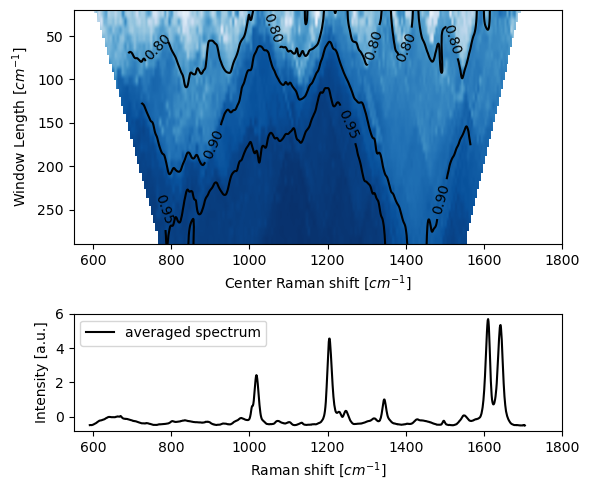

In [51]:
reload_libraries()
min_wavelength = 550
max_wavelength = 1800


# Create a figure with subplots and adjust the height ratios
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), gridspec_kw={'height_ratios': [2, 1]})

# Plot intensity plot (imshow) on the first subplot (top)
x_labels = heatmap_df.columns
y_labels = heatmap_df.index
extent = [x_labels.min(), x_labels.max(), y_labels.max(), y_labels.min()]
img = ax1.imshow(heatmap_df, aspect='auto', cmap='Blues', extent=extent)
# Add contour lines to the intensity plot
extent = [x_labels.min(), x_labels.max(), y_labels.min(), y_labels.max()]
contour_levels = [0.5, 0.8, 0.9, 0.95]  # Define contour levels as needed
gaussian_filtered_heatmap_df = gaussian_filter(heatmap_df, sigma =2)
contour = ax1.contour(gaussian_filtered_heatmap_df,levels=contour_levels, colors='black', extent = extent)  # Adjust colors and levels as needed
# Label contour lines
contour_labels = plt.clabel(contour, inline=True, fmt='%1.2f', fontsize=10, colors = 'black')
ax1.set_xlabel(fln.window_plot_x)
ax1.set_ylabel(fln.window_plot_y)
# ax1.colorbar(img)  # You can add a color bar if needed
ax1.set_xlim(min_wavelength, max_wavelength)

# Plot lineplot on the second subplot (bottom)
mean_spectrum = mf.get_mean_spectrum(melt_df)
sns.lineplot(data=mean_spectrum, x='wavelength', y='intensity', ax=ax2, color = 'black', label = 'averaged spectrum')
ax2.set_xlim(min_wavelength, max_wavelength)
ax2.set_xlabel(fln.spectrum_x)
ax2.set_ylabel(fln.spectrum_y)

# ax2.axhline(y = 2, xmin = 0.3, xmax=0.7)

plt.tight_layout()
plt.savefig(fp.figure_filepath + '/' + 'model_performance_window_length.png', bbox_inches = 'tight')
plt.show()